<a href="https://colab.research.google.com/github/nathaliedees/thesis/blob/master/cnn_orthophotomosaic_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
from PIL import Image as Img
from PIL import ImageTk

import os
import sklearn.preprocessing as skl


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/'My Drive'/Master/Data

/content/drive/My Drive/Master/Data


In [4]:
%ls

aug/


In [16]:
%matplotlib inline
import torch
import fastai
#from fastai.tabular.all import *
from fastai.text.all import *
from fastai.vision.all import *
from fastai.data.external import *
from fastai import *
from fastai.collab import *
# etc, etc, etc

path=Path('/content/drive/My Drive/Master/Data/aug')

In [17]:
path.ls()

(#5) [Path('/content/drive/My Drive/Master/Data/aug/test'),Path('/content/drive/My Drive/Master/Data/aug/results'),Path('/content/drive/My Drive/Master/Data/aug/backup'),Path('/content/drive/My Drive/Master/Data/aug/trainAnnotate'),Path('/content/drive/My Drive/Master/Data/aug/trainData')]

In [18]:
#import training images
fnames = get_image_files(path/'trainData')
fnames[:5]

(#5) [Path('/content/drive/My Drive/Master/Data/aug/trainData/augmented_1.png'),Path('/content/drive/My Drive/Master/Data/aug/trainData/augmented_4.png'),Path('/content/drive/My Drive/Master/Data/aug/trainData/augmented_3.png'),Path('/content/drive/My Drive/Master/Data/aug/trainData/augmented_2.png'),Path('/content/drive/My Drive/Master/Data/aug/trainData/augmented_12.png')]

In [19]:
#import training labels
lbl_names = get_image_files(path/'trainAnnotate')
lbl_names[:5]


(#5) [Path('/content/drive/My Drive/Master/Data/aug/trainAnnotate/augmented_3.png'),Path('/content/drive/My Drive/Master/Data/aug/trainAnnotate/augmented_2.png'),Path('/content/drive/My Drive/Master/Data/aug/trainAnnotate/augmented_4.png'),Path('/content/drive/My Drive/Master/Data/aug/trainAnnotate/augmented_1.png'),Path('/content/drive/My Drive/Master/Data/aug/trainAnnotate/augmented_11.png')]

In [20]:
#make sure every label matches with training image
def get_y_fn(x): return Path(str(x.parent)[:-4]+'Annotate')/x.name

In [21]:
x=get_y_fn(path/'trainData/augmented_60.png')
x

Path('/content/drive/My Drive/Master/Data/aug/trainAnnotate/augmented_60.png')

In [22]:
r_index = random.randint(0, len(fnames)-1)
#show some data
img_f = fnames[10]
img = open_image(img_f)
img.show(figsize=(8,8))

#show mask
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

#sr_size=np.array(img.shape[1:])
img.data

NameError: ignored

In [28]:
src_size = np.array(mask.shape[1:])
print(mask)
src_size,mask.data

print('Size: {}'.format(src_size))
t = mask.data
a = t.reshape(1, -1).squeeze()
n = to_np(a)
u = []
for i in n:
  if i not in u:
    u.append(i)
print(sorted(u))
len(u)

ImageSegment (1, 512, 512)
Size: [512 512]
[0, 1, 3]


3

In [12]:
codes = np.array(['nodata',
         'coral', 
         'rocks', 
         'rubble', 
         'shallow water/sand', 
         'waves'])

In [13]:
bs = 2

In [23]:
data = (SegmentationItemList.from_folder(path/'trainData')
       #.split_by_folder(train=train, valid=path/'aug/valData') #splitting data by folder (make separate validation set)
       #.split_none()                                           #do not split data
       .split_by_rand_pct(0.25)                                  #split random -> put one of these on
       .label_from_func(get_y_fn, classes=codes)
       #.transform()                 #extra random transformations on 10% of the dataset
       .databunch(bs=bs).normalize())
       #.normalize())                                            #can be normalized on imagenetstats

AttributeError: ignored

In [32]:
#add test set
test_data = ImageList.from_folder(path/'test')

test_data[200]
data.add_test(test_data)

In [33]:
data

ImageDataBunch;

Train: LabelList (83 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: /content/drive/My Drive/Master/Data/aug/trainData;

Valid: LabelList (27 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: /content/drive/My Drive/Master/Data/aug/trainData;

Test: LabelList (410 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: EmptyLabelList
,,,,
Path: /content/drive/My Drive/Master/Data/aug/trainData

In [34]:
print(data.classes)

['nodata' 'coral' 'rocks' 'rubble' 'shallow water/sand' 'waves']


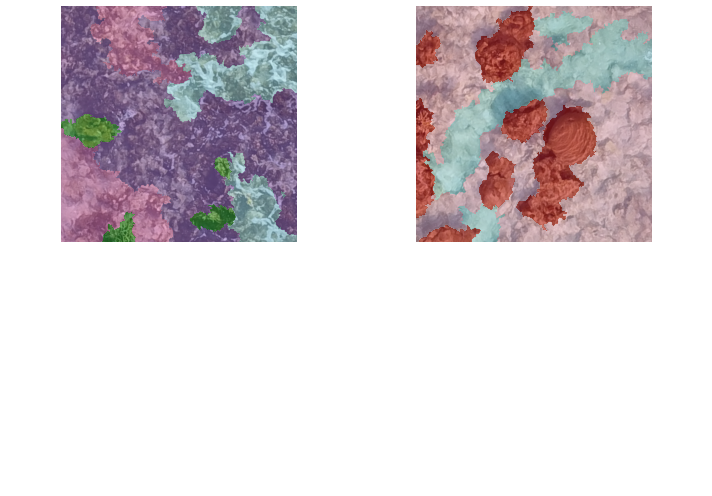

In [35]:
data.show_batch(2, figsize=(10,7))

In [36]:
#https://forums.fast.ai/t/create-databunch-with-multiple-segmentation-mask-as-label/53643/21
#custom accuracy class, otherwise the learner does not work due to tensor size errors.
def cust_accuracy(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    return (input==targs).float().mean()

In [37]:
#https://forums.fast.ai/t/multi-class-semantic-segmentation-metrics-and-accuracy/74665/3
# Return Jaccard index, or Intersection over Union (IoU) value
def IoU(preds:Tensor, targs:Tensor, eps:float=1e-8):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Notes: [Batch size,Num classes,Height,Width]
    Args:
        targs: a tensor of shape [B, H, W] or [B, 1, H, W].
        preds: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model. (prediction)
        eps: added to the denominator for numerical stability.
    Returns:
        iou: the average class intersection over union value 
             for multi-class image segmentation
    """
    num_classes = preds.shape[1]
    
    # Single class segmentation?
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[targs.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(preds)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
        
    # Multi-class segmentation
    else:
        # Convert target to one-hot encoding
        # true_1_hot = torch.eye(num_classes)[torch.squeeze(targs,1)]
        true_1_hot = torch.eye(num_classes)[targs.squeeze(1)]
        
        # Permute [B,H,W,C] to [B,C,H,W]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        
        # Take softmax along class dimension; all class probs add to 1 (per pixel)
        probas = F.softmax(preds, dim=1)
        
    true_1_hot = true_1_hot.type(preds.type())
    
    # Sum probabilities by class and across batch images
    dims = (0,) + tuple(range(2, targs.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims) # [class0,class1,class2,...]
    cardinality = torch.sum(probas + true_1_hot, dims)  # [class0,class1,class2,...]
    union = cardinality - intersection
    iou = (intersection / (union + eps)).mean()   # find mean of class IoU values
    return iou

In [48]:
wd=0.01
learn = unet_learner(data, models.resnet34, 
                     metrics=[cust_accuracy, 
                              IoU, 
                              Precision(average='micro'),
                              FBeta(average='micro'), 
                              Recall(average='micro')], 
                     #wd=wd) 
                     loss_func = nn.CrossEntropyLossFlat())  #still need to add loss function instead of weight decay, for now weight decay works fine
                     #bottle=True)

AttributeError: ignored

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


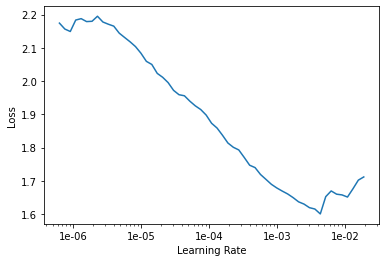

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
#chose best lr from plot
lr=1e-4

In [ ]:
learn.fit_one_cycle(5, slice(lr))
#if this worked fine; no weird numbers and nans, tweaking can beglearnin

epoch,train_loss,valid_loss,cust_accuracy,IoU,time
0,1.432936,1.220304,0.450854,0.117423,01:05
1,1.268730,1.157250,0.510400,0.124223,01:00
2,1.196952,1.156604,0.485306,0.144645,01:00
3,1.150960,1.116024,0.530129,0.148709,01:00
4,1.117153,1.105077,0.535285,0.166307,01:00


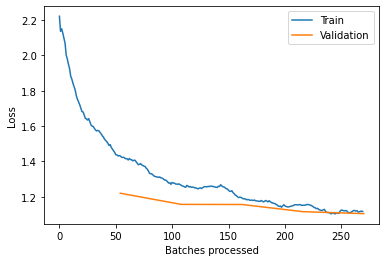

In [ ]:
learn.recorder.plot_losses()

In [ ]:
lrs = slice(lr/100,lr)
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,cust_accuracy,IoU,time
0,1.118569,1.121120,0.508326,0.164900,01:01
1,1.126182,1.102515,0.530080,0.170362,01:00
2,1.077381,1.066290,0.545932,0.205462,01:00
3,1.075084,1.053573,0.555853,0.253081,01:00
4,0.992382,1.021866,0.565152,0.269801,01:00


In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

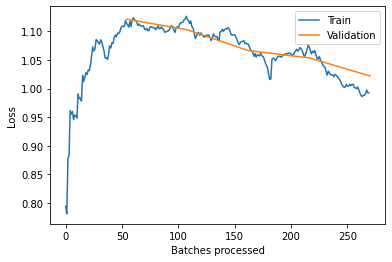

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,cust_accuracy,IoU,time
0,0.884081,1.056232,0.569802,0.288031,01:05
1,0.877551,1.052599,0.562799,0.291302,01:03
2,0.843470,1.037893,0.566124,0.293697,01:03
3,0.794764,0.987988,0.591024,0.315062,01:03
4,0.730654,1.034656,0.576368,0.324176,01:03
5,0.686764,1.019791,0.598029,0.336786,01:03
6,0.652975,1.165135,0.542916,0.314024,01:03
7,0.589961,0.917050,0.644640,0.342546,01:03
8,0.581363,1.078734,0.581246,0.312291,01:03
9,0.528885,0.995125,0.616961,0.348958,01:03


In [ ]:
learn.save('stage-2');

In [ ]:
learn.load('stage-2');

In [ ]:
learn.fit_one_cycle(5, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,cust_accuracy,IoU,time
0,0.321625,0.889225,0.671185,0.396853,01:04
1,0.318052,0.944687,0.666335,0.395590,01:04
2,0.348679,1.055972,0.628970,0.361609,01:03
3,0.362526,0.896120,0.681805,0.390017,01:04
4,0.325138,0.884789,0.681946,0.404260,01:04


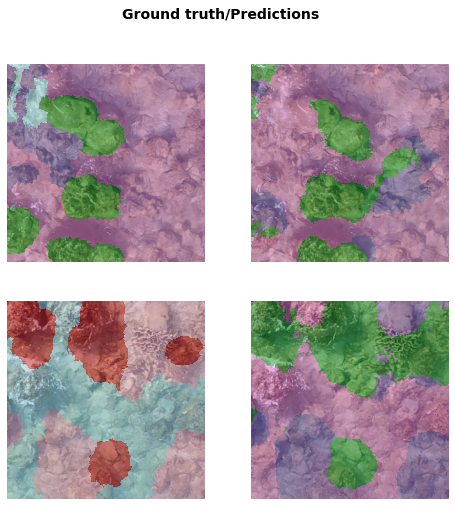

In [ ]:
learn.show_results()

In [ ]:
valids =learn.get_preds(ds_type = DatasetType.Valid)
valids[0].shape

torch.Size([32, 6, 512, 512])

array([[0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 2, 2, 2, ..., 3, 3, 3, 0],
       [0, 2, 2, 2, ..., 3, 3, 3, 0],
       [0, 2, 2, 2, ..., 3, 2, 3, 0],
       ...,
       [0, 2, 2, 2, ..., 3, 3, 3, 0],
       [0, 2, 2, 2, ..., 3, 3, 3, 0],
       [0, 2, 2, 2, ..., 3, 3, 2, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0]])

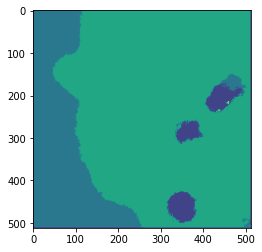

In [ ]:
predicted_masks = np.argmax(valids[0],axis=1)
for i in range(len(predicted_masks)):
  Mask = (to_np(predicted_masks[i]))
  plt.imshow(Mask)

Mask

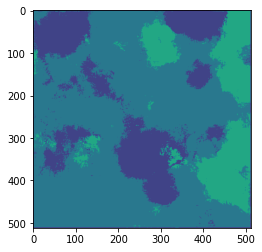

In [ ]:
pred_v = valids[0][10]
pred_argmax = pred_v.argmax(dim=0)
plt.imshow(pred_argmax)

In [ ]:
ground_truth = []
classified = []

for i in range (len(learn.data.valid_ds)):
    ground_truth.append(data.valid_ds[i][1])
    pred_v = valids[0][i]
    pred_argmax = pred_v.argmax(dim=0)
    classified.append(pred_argmax)

In [ ]:
#make custom function to make a confusion matrix
#for now, build in functions do not work
#import sklearn
#from sklearn.metrics import multilabel_confusion_matrix
#labels = ['0', '2', '1', '3','4','5'] #if string_type else" [0, 2, 1, 3, 4, 5]
#sklearn.metrics.multilabel_confusion_matrix(ground_truth, classified, labels=labels)

ValueError: ignored

In [ ]:
#When happy with the results, try them on the test set
test_preds=learn.get_preds(ds_type = DatasetType.Test)

In [ ]:
#https://forums.fast.ai/t/get-the-filenames-of-the-data-in-the-test-set-in-the-order-theyre-predicted/46056/6
#fast.ai feeds databunches the order of test data randomly, so assign right filenames with the right maskmask
datasetIndex = []
num = len(learn.data.test_ds)

for i in range(num):
    datasetIndex.append(str(learn.data.test_ds.items[i]).split('/')[-1])

In [ ]:
datasetIndex[1]

'tile_0220.png'

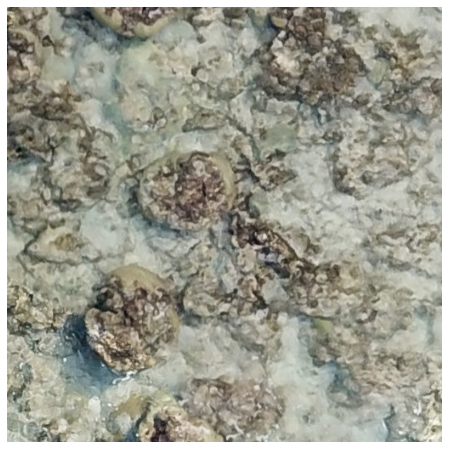

In [ ]:
testnames = get_image_files(path/'test')
#show some data
img_t = testnames[1]
img = open_image(img_t)
img.show(figsize=(8,8))

In [ ]:
#https://forums.fast.ai/t/saving-segmentation-masks-tutorial/62898
#followed this tutorial for saving the masks
test_preds[0].shape

torch.Size([410, 6, 512, 512])

In [ ]:
pred_1 = test_preds[0][1]
pred_argmax = pred_1.argmax(dim=0)

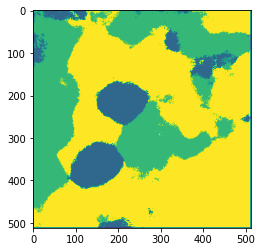

In [ ]:
plt.imshow(pred_argmax)

In [ ]:
#saving masks of testset
for i in range (0,410):
  pred_1 = test_preds[0][i]
  pred_argmax = pred_1.argmax(dim=0)
  pred_argmax = pred_argmax.numpy()
  rescaled = (255.0/pred_argmax.max() * (pred_argmax - pred_argmax.min())).astype(np.uint8)
  im = Img.fromarray(rescaled)

  im.save(str(path) + '/results/' + datasetIndex[i][:-4]+'.png')

